In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

In [19]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [20]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [21]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [22]:
Base.classes.keys()

['measurement', 'station']

In [23]:
M = Base.classes.measurement
S = Base.classes.station

In [24]:
session = Session(engine)

#### Precipitation Analysis

In [27]:
#session.query(M.date).order_by(M.date.desc()).all() #('2017-08-23')
result1=session.query(M.date, M.prcp).filter(M.date>'2016-08-23').all()
#result1

In [28]:
df1=pd.DataFrame(result1, columns=['date','prcp'])
df1.set_index('date', inplace=True)
df1=df1.sort_values('date')
#df1

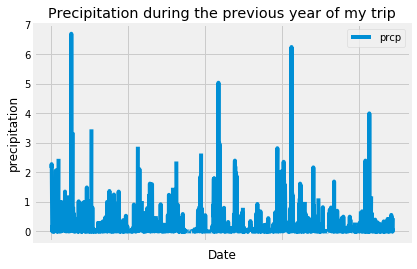

<Figure size 432x288 with 0 Axes>

In [29]:
%matplotlib inline
df1.plot()
plt.title("Precipitation during the previous year of my trip")
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.show()
plt.tight_layout()
#plt.savefig("precipitaion_over_year.png")

In [30]:
df1.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


####  Station Analysis

In [31]:
# total number of stations: 9
session.query(S.station).count()

9

In [32]:
# checking the first date/last date of the dataset
session.query(M.date).order_by(M.date).first()     #('2010-01-01')
session.query(M.date).order_by(M.date.desc()).first() #('2017-08-23')

('2017-08-23')

In [33]:
#1) Total(over 6 years) frequency for tobs data
sel=[M.station,func.count(M.tobs)]
session.query(*sel).group_by(M.station).order_by(func.count(M.tobs).desc()).all()
# the most active station:'USC00519281'

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
#Over 6-year tobs(min, max, avg) results for the stations
sel=[M.station, func.min(M.tobs),func.max(M.tobs),func.avg(M.tobs)]
session.query(*sel).group_by(M.station).all()

[('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784),
 ('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00519523', 56.0, 85.0, 74.5436493068565)]

In [35]:
#2) 1-year frequency for tobs data
sel=[M.station,func.count(M.tobs)]
session.query(*sel).filter(M.date>'2016-08-23')\
.group_by(M.station).order_by(func.count(M.tobs).desc()).all()
# the most active station:'USC00519397'

[('USC00519397', 360),
 ('USC00519281', 351),
 ('USC00516128', 348),
 ('USC00513117', 342),
 ('USC00519523', 336),
 ('USC00514830', 304),
 ('USC00517948', 182)]

In [36]:
#Filter by the station with the highest number of observations.
# last year's tobs(min, max, avg) for the most active station 'USC00519397'
sel=[M.station, func.min(M.tobs),func.max(M.tobs),func.avg(M.tobs)]
session.query(*sel).filter(M.station=='USC00519397').all()

[('USC00519397', 56.0, 87.0, 74.55323054331865)]

In [41]:
ttobs=session.query(M.tobs).filter(M.date>'2016-08-23').filter(M.station=='USC00519397').all()
df2=pd.DataFrame(ttobs, columns=['tobs'])
#df2

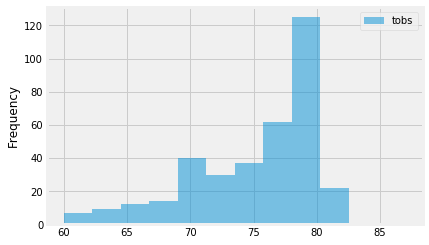

In [42]:
%matplotlib inline
df2.plot(kind='hist', density=0, bins=12, stacked=False, alpha=.5)

In [74]:
# If we choose the most active station over 6 years, and do the last year's analysis on it,
ttobs_b=session.query(M.tobs).filter(M.date>'2016-08-23').filter(M.station=='USC00519281').all()
df2b=pd.DataFrame(ttobs_b, columns=['tobs'])
#df2b

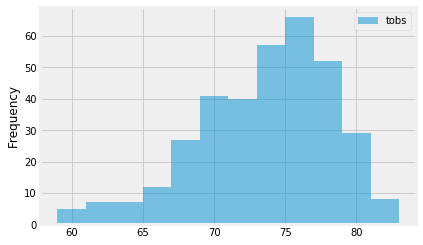

In [75]:
%matplotlib inline
df2b.plot(kind='hist', density=0, bins=12, stacked=False, alpha=.5)

#### Temperature Analysis

In [44]:
def calc_temps(start_date, end_date):  
    return session.query(func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)).\
        filter(M.date >= start_date).filter(M.date <= end_date).all()

In [45]:
# MY trip starts from 2018-05-01 and ends at 2018-05-06
temps=calc_temps('2017-05-01', '2017-05-06')
temps

[(65.0, 75.71428571428571, 80.0)]

In [53]:
#t_low=temps[0][0]
#t_avg=temps[0][1]
#t_high=temps[0][2]
#t_yerr=high-low

In [58]:
df3=pd.DataFrame(temps, columns=['low','avg','high'])
#df3.set_index('station', inplace=True)
df3['yerr']=df3['high']-df3['low']
df3=df3[['avg','yerr']]
df3

,avg,yerr
0,75.714286,15.0


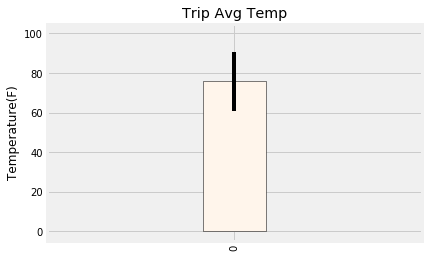

In [59]:
%matplotlib inline
df3['avg'].plot(kind='bar',yerr=df3['yerr'],colormap='Oranges',edgecolor='black',width=0.1)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature(F)")
plt.ylim(-5, 105)

plt.show()

####  Daily Rainfall Average

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[S.station, S.name, S.latitude, S.longitude, S.elevation, func.sum(M.prcp),]
session.query(*sel).filter(M.station==S.station).filter(M.date >='2017-05-01')\
.filter(M.date <= '2017-05-06').group_by(M.station).order_by(func.sum(M.prcp).desc()).all()

[('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.47000000000000003),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.35),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.26),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.15000000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.11),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.07)]

In [64]:
def daily_normals(date):
    sel = [func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", M.date) == date).all()

In [65]:
data = ['05-01', '05-02', '05-03', '05-04', '05-05', '05-06']
#data
data_0=['2018-05-01','2018-05-02','2018-05-03','2018-05-04','2018-05-05','2018-05-06']
#data_0

In [66]:
# calculate the daily normals for your trip
r=[]
for x in data:
    temp=daily_normals(x)
    r.append(temp)  
r

[[(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)],
 [(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)]]

In [69]:
df4=pd.DataFrame(r, columns=['ttemp'])
#create dataframe df4 and df4a
df4['min']=df4['ttemp'].str[0]
df4['avg']=df4['ttemp'].str[1]
df4['max']=df4['ttemp'].str[1]
df4.drop(['ttemp'], axis=1, inplace=True)

df4a=pd.DataFrame(data_0,columns=['date'])

In [71]:
df4_m = df4a.join(df4).set_index('date')
df4_m

,min,avg,max
date,,,
2018-05-01,65.0,72.759259,72.759259
2018-05-02,65.0,73.050847,73.050847
2018-05-03,67.0,73.410714,73.410714
2018-05-04,65.0,73.596491,73.596491
2018-05-05,67.0,73.396552,73.396552
2018-05-06,66.0,73.140351,73.140351


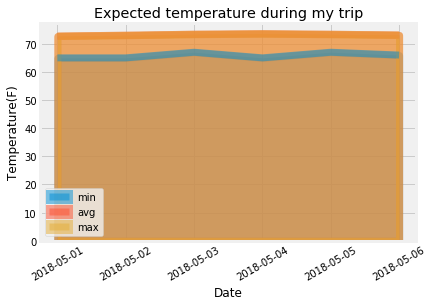

<Figure size 432x288 with 0 Axes>

In [73]:
%matplotlib inline

x = np.arange(6)
df4_m.plot.area(stacked=False,linewidth=7)
x_ticks=[value for value in x]
plt.xticks(x_ticks, data_0,rotation=30)
plt.title("Expected temperature during my trip")
plt.xlabel("Date")
plt.ylabel("Temperature(F)")
plt.show()
plt.tight_layout()
#plt.savefig("temp_over_trip.png")